# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla SGD, batch SGD and minibatch SGD. For this we consider a linear model with only one weight and one bias (the slope and the offset).

We also show how to use the dataset API with a custom model and that the model is the continuation of the input pipeline.

> (!!!) We use here the kernel `miniconda-sumsch`.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.VERSION

'1.12.0'

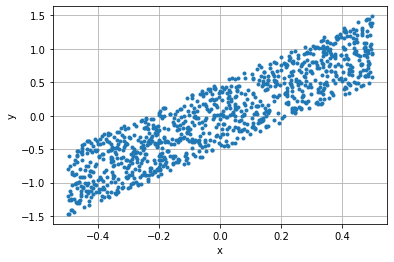

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
ref_slope = 2.0
ref_offset = 0.0
noise = np.random.random((nsamples, 1)) - 0.5    # -0.5 to center the noise
x_train = np.random.random((nsamples, 1)) - 0.5  # -0.5 to center x around 0
y_train = ref_slope * x_train + ref_offset + noise

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

### 1. Create a dataset object and define an input pipeline with the `tf.data` API.

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32),
                                              y_train.astype(np.float32)))
dataset = dataset.batch(1000)                 # Set a batch size. Now iterating over the dataset will be in batches of 1000 samples.
dataset = dataset.repeat(100)                 # Iterate 100 times over the dataset.
iterator = dataset.make_one_shot_iterator()   # Create an iterator from the dataset object.
next_item = iterator.get_next()               # A batch `(x_train, y_train)` to be fetched and passed to the model.

### 2. Define the model

In [5]:
# The model has two variables `slope` and `offset`.
# These are the values we want to find during training.
slope = tf.Variable(np.random.randn() , name='slope')
offset = tf.Variable(np.random.randn() , name='offset')

# We connect now the model to the input pipeline,
# `x`, `y` will be the data passed to the model.
# The model is the continuation of the pipeline!
x, y = next_item

# We define now the model itself.
# `y_hat` is the value output by the model when
# a data batch `x` is passed.
y_hat = slope * x + offset

# Define a loss to minimize
loss = tf.losses.mean_squared_error(y_hat, y)

# Choose an optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.5)

# The training is minimizing the loss
train = opt.minimize(loss)

# initialize `slope` and `offset`
init = tf.global_variables_initializer()

### 3. Training

In [6]:
history = []

with tf.Session() as sess:
    sess.run(init)
    try:
        while True:
            _, loss_val = sess.run((train, loss))  # Run all operations together!!!
            history.append([sess.run(slope),sess.run(offset), loss_val])
    except tf.errors.OutOfRangeError:
        print('Training finished')        

Training finished


### Some plots

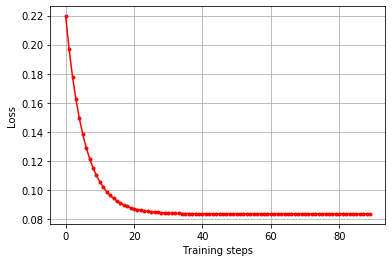

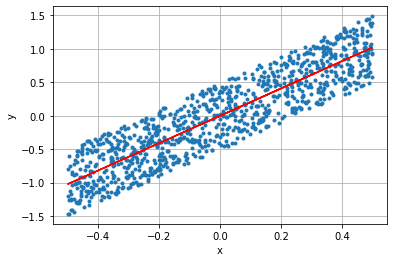

In [7]:
slope_hist = np.array(history)[:, 0]
offset_hist = np.array(history)[:, 1]
loss_hist = np.array(history)[:, 2]

plt.plot(loss_hist[10:], 'r.-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.plot(x_train, y_train, '.')
plt.plot(x_train, slope_hist[-1] * x_train + offset_hist[-1], 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

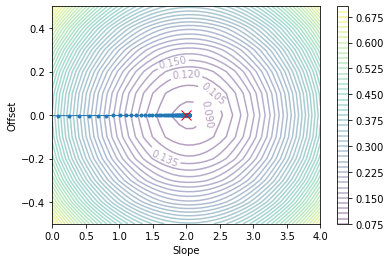

In [8]:
def loss_function_field(m, n, xref, yref):
    return np.mean(np.square(yref - m * xref - n ))

_m = np.arange(-0, 4.01, 0.1)
_n = np.arange(-0.5, 0.51, 0.1)
M, N = np.meshgrid(_m, _n)

Z = np.zeros(M.shape)
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        Z[i, j] = loss_function_field(M[i, j], N[i, j],
                                      x_train, y_train)
        
#matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

cp = plt.contour(M, N, Z, 50, vmin=Z.min(), vmax=Z.max(), alpha=0.4)
plt.clabel(cp, cp.levels[:6])
plt.colorbar()
m = slope_hist[-1]
n = offset_hist[-1]
plt.plot(slope_hist, offset_hist, '.-', lw=1)
plt.plot([ref_slope], [ref_offset], 'rx', ms=10)
plt.xlim([_m.min(), _m.max()])
plt.ylim([_n.min(), _n.max()])
plt.xlabel('Slope')
plt.ylabel('Offset')
plt.show()

#matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)